In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 10)

In [3]:
#%% settings
#for windows
#file = 'sample_data\\201805\\RL7785--1K-20180517102718_crv.csv'
#file_rlt = 'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv'
file = 'sample_data/201805/RL7797--1K-20180525135150_crv.csv'
file_rlt = 'sample_data/201805/RL7797--1K-20180525135150_rlt.csv'

In [4]:
#%% read files and parameters
data = pd.read_csv(file, sep=',', encoding='shift_jis', skiprows=1, index_col=0)
data_rlt = pd.read_csv(file_rlt, sep=',', encoding='shift_jis')
data.head()

,mm,N,mm.1,N.1,mm.2,N.2,mm.3,N.3,mm.4,N.4
1,0.000,0.10,0.000,0.10,0.000,0.10,0.000,0.11,0.000,0.11
2,0.001,0.18,0.001,0.14,0.001,0.12,0.001,0.18,0.001,0.12
3,0.002,0.26,0.002,0.24,0.002,0.22,0.002,0.26,0.002,0.20
4,0.003,0.37,0.003,0.35,0.003,0.34,0.003,0.35,0.003,0.25
5,0.004,0.43,0.004,0.46,0.004,0.43,0.004,0.47,0.004,0.32


In [5]:
L = 64  # span
b = float(data_rlt.iloc[2, 3]) # width of first specimen
h = float(data_rlt.iloc[2, 4]) # height of first specimen
print('span, width, height of first specimen:', L, ',', b, ',', h)

span, width, height of first specimen: 64 , 9.84 , 3.83


In [6]:
#cut out curve of first specimen
col = ['mm', 'N']
data = data.reindex(columns=col)
data

,mm,N
1,0.000,0.10
2,0.001,0.18
3,0.002,0.26
4,0.003,0.37
5,0.004,0.43
...,...,...
483,4.249,255.00
484,4.349,255.00
485,NaN,NaN
486,NaN,NaN


In [7]:
#%% convert (mm, N) to (%, MPa)
# sigma = 3*F*L / (2*b*h^2)
# epsilon = 6*100*s*h / (L^2)
# F: load, L:span = 64 mm, b:width, h:height, s=strain/mm

data['strain'] = data['mm'] * 6 * 100 * h / L / L
data['stress'] = data['N'] * 3 * L / (2 * b * h * h)
data.dropna(subset=['mm'], inplace=True)

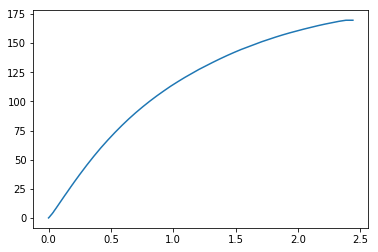

In [8]:
plt.plot(data['strain'], data['stress'])
plt.xlabel = 'strain / %'
plt.ylabel = 'stress / N'
plt.show()

In [53]:
#%% data thinnings
max_strain = 10
interval = 0.1
interval_steps = int(max_strain/interval)
marker = pd.DataFrame({'strain': np.round(np.linspace(0, max_strain, interval_steps, endpoint=False), 2), 'marker': True})
data_marked = pd.merge(data, marker, on='strain', how='outer')
data_marked.sort_values(by=['strain'], inplace=True)
data_marked.rename(data_marked['strain'], inplace=True)
data_marked.interpolate(method='slinear', limit=1, inplace=True)

In [54]:
data_marked['marker'].fillna('False', inplace=True)
data_skipped = data_marked[data_marked['marker']==True]
data_skipped

,mm,N,strain,stress,marker
0.0,0.000000,0.100000,0.0,0.066509,True
0.1,0.178242,21.979356,0.1,14.618188,True
0.2,0.356484,45.098390,0.2,29.994362,True
0.3,0.534726,66.752739,0.3,44.396392,True
0.4,0.712968,86.732522,0.4,57.684690,True
...,...,...,...,...,...
9.5,NaN,NaN,9.5,NaN,True
9.6,NaN,NaN,9.6,NaN,True
9.7,NaN,NaN,9.7,NaN,True
9.8,NaN,NaN,9.8,NaN,True


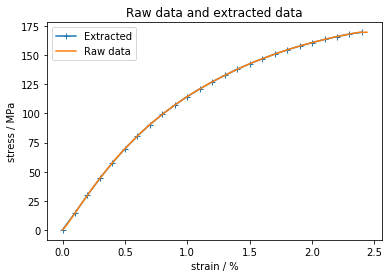

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_skipped['strain'], data_skipped['stress'], marker='+', label='Extracted')
ax.plot(data['strain'], data['stress'], label='Raw data')
ax.set_xlabel('strain / %')
ax.set_ylabel('stress / MPa')
ax.set_title('Raw data and extracted data')
ax.legend(loc='best')
plt.show()

In [56]:
thinnedSS = data_skipped['stress']
thinnedSS

0.0     0.066509
0.1    14.618188
0.2    29.994362
0.3    44.396392
0.4    57.684690
         ...    
9.5          NaN
9.6          NaN
9.7          NaN
9.8          NaN
9.9          NaN
Name: stress, Length: 100, dtype: float64

In [57]:
    file = {'name':'RL7785',
            'crv':'sample_data/201805/RL7785--1K-20180517102718_crv.csv', 
            'rlt':'sample_data/201805/RL7785--1K-20180517102718_rlt.csv',
            'set':'sample_data/201805/RL7785--1K-20180517102718_set.csv'}
    #for windows
    #file = {'crv':'sample_data\\201805\\RL7785--1K-20180517102718_crv.csv', 
    #        'rlt':'sample_data\\201805\\RL7785--1K-20180517102718_rlt.csv',
    #        'set':'sample_data\\201805\\RL7785--1K-20180517102718_set.csv'}
    file['crv']

'sample_data/201805/RL7785--1K-20180517102718_crv.csv'

In [58]:
def thinningSS(file, max_strain=10, interval=0.1):
    '''a function to conduct data thinning of SS curve at range (0, MAX_STRAIN), with INTERVAL
    This returns np.series of stress with strain in the index. 
    FILE should be passed as dictionary containing following: 
        'name': name of sample like 'RL7785'
        'crv': path(relative) of xxx_crv.csv file
        'rlt': path(relative) of xxx_rlt.csv file
        'set': path(relative) of xxx_set.csv file
    '''
    
    # read files and parameters
    data = pd.read_csv(file['crv'], sep=',', encoding='shift_jis', skiprows=1, index_col=0)
    data_rlt = pd.read_csv(file['rlt'], sep=',', encoding='shift_jis')
    L = 64  # span
    b = float(data_rlt.iloc[2, 3]) # width of first specimen
    h = float(data_rlt.iloc[2, 4]) # height of first specimen
    #print('span, width, height of first specimen:', L, ',', b, ',', h)#cut out curve of first specimen
    col = ['mm', 'N']
    data = data.reindex(columns=col)
    data.dropna(subset=['mm'], inplace=True)
    
    #%% convert (mm, N) to (%, MPa)
    # sigma = 3*F*L / (2*b*h^2)
    # epsilon = 6*100*s*h / (L^2)
    # F: load, L:span = 64 mm, b:width, h:height, s=strain/mm
    data['strain'] = data['mm'] * 6 * 100 * h / L / L
    data['stress'] = data['N'] * 3 * L / (2 * b * h * h)
    
    #%% data thinnings
    interval_steps = int(max_strain/interval)
    marker = pd.DataFrame({'strain': np.round(np.linspace(0, max_strain, interval_steps, endpoint=False), 2), 'marker': True})
    data_marked = pd.merge(data, marker, on='strain', how='outer')
    data_marked.rename(data_marked['strain'], inplace=True)
    data_marked.sort_values(by=['strain'], inplace=True)
    data_marked.interpolate(method='slinear', limit=1, inplace=True)
    data_marked['marker'].fillna('False', inplace=True)
    data_skipped = data_marked[data_marked['marker']==True]
    thinnedSS = data_skipped['stress']
    thinnedSS.name = file['name']
    
    return thinnedSS


In [59]:
test = thinningSS(file)

In [60]:
test.to_dict()

{0.0: 0.06284734188431813,
 0.1: 10.310726413069156,
 0.2: 20.46656745049489,
 0.3: 29.52391527863469,
 0.4: 37.765504741873414,
 0.5: 45.18511509507796,
 0.6: 51.778390435978416,
 0.7: 57.56174487957866,
 0.8: 62.64115787845261,
 0.9: 67.14719930028025,
 1.0: 71.08960482572621,
 1.1: 74.52356287613469,
 1.2: 77.53087854670868,
 1.3: 80.14995058093494,
 1.4: 82.4261076573369,
 1.5: 84.41450250027538,
 1.6: 86.19029968099682,
 1.7: 87.53533634807465,
 1.8: 87.97674400328802,
 1.9: nan,
 2.0: nan,
 2.1: nan,
 2.2: nan,
 2.3: nan,
 2.4: nan,
 2.5: nan,
 2.6: nan,
 2.7: nan,
 2.8: nan,
 2.9: nan,
 3.0: nan,
 3.1: nan,
 3.2: nan,
 3.3: nan,
 3.4: nan,
 3.5: nan,
 3.6: nan,
 3.7: nan,
 3.8: nan,
 3.9: nan,
 4.0: nan,
 4.1: nan,
 4.2: nan,
 4.3: nan,
 4.4: nan,
 4.5: nan,
 4.6: nan,
 4.7: nan,
 4.8: nan,
 4.9: nan,
 5.0: nan,
 5.1: nan,
 5.2: nan,
 5.3: nan,
 5.4: nan,
 5.5: nan,
 5.6: nan,
 5.7: nan,
 5.8: nan,
 5.9: nan,
 6.0: nan,
 6.1: nan,
 6.2: nan,
 6.3: nan,
 6.4: nan,
 6.5: nan,
 6.6